In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import scipy.cluster.hierarchy as sch #用于进行层次聚类，画层次聚类图的工具包
import scipy.spatial.distance as ssd
from scipy.cluster.vq import vq,kmeans,whiten


In [8]:
size = 32
cluster_mean = [(0,0), (7,6), (-5, 4)]
cluster_covar = [[[2,1], [1,2]],
                 [[4,2], [2,3]],
                 [[1,0], [0,3]]]
data = []
label = []
# 基于多维高斯分布生成模拟数据
for i, (mean, cov) in enumerate(zip(cluster_mean, cluster_covar)):
    data += np.random.multivariate_normal(mean, cov, size).tolist()
    label += [i] * size

In [9]:
def show(data, label=None):
    t = list(zip(*data))
    x,y = t[0], t[1]
    sns.scatterplot(x, y, hue=label)
    plt.axis()

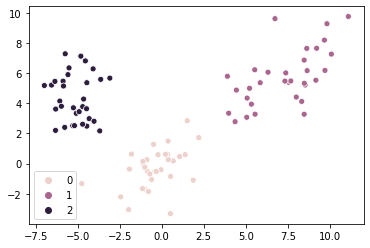

In [10]:
show(data, label)

In [21]:
import time
import copy
class K_medoid:
    def __init__(self, cluster_size, max_iter):
        self.cluster_size = cluster_size
        self.max_iter = max_iter
        self.verbose_eval = 5
        self.centers = None
        self.labels = None
        self.last_labels = None
        
    def expection(self, data):
        centers = np.empty((0, data.shape[1]))
        for i in range(self.cluster_size):
            idx = (self.labels == i)
            center_samples = data[idx]
            if len(center_samples) > 0:
                tmp = float('inf')
                for sample in center_samples:
                    dist_total = np.sum(np.sum(np.square(center_samples - sample), axis=1),axis=0)
                    if np.sum(dist_total) < tmp:
                        tmp = dist_total
                        center = sample
                center = copy.deepcopy(center)
            else:
                center = self.centers[i]
            centers = np.vstack((centers, center[np.newaxis, :]))
        self.centers = centers
        
    def maximization(self, data):
        labels = np.empty((data.shape[0]))
        dists = np.empty((0, self.cluster_size))
        for i, sample in enumerate(data):
            dist = self.l2_norm(sample)
            labels[i] = np.argmin(dist)
            dists = np.vstack((dists, dist))
            
        self.dists = dists
        self.last_labels = self.labels
        self.labels = labels
        
    def l2_norm(self, sample):
        return np.sum(np.square(self.centers-sample), axis=1)
    
    def init_centers(self, data):
        init_row = np.random.choice(range(data.shape[0]), self.cluster_size, replace=False)
        self.centers = data[init_row]
        
    def fit(self, data):
        self.init_centers(data)
        for i in range(self.max_iter):
            print("Epoch :",i)
            self.maximization(data)
            self.expection(data)
            if (self.last_labels == self.labels).all():
                print("K-medoid Itertion Converge")
                break
    
    
class Kmeans:
    
    def __init__(self, cluster_size, max_iter):
        self.cluster_size = cluster_size
        self.max_iter = max_iter
        self.verbose_eval = 5
        self.centers = None
        self.labels = None
        self.last_labels = None
        
    def expection(self, data):
        centers = np.empty((0, data.shape[1]))
        for i in range(self.cluster_size):
            idx = (self.labels == i)
            center_samples = data[idx]
            if len(center_samples) > 0:
                center = np.mean(center_samples, axis=0)
            else:
                center = self.centers[i]
            centers = np.vstack((centers, center[np.newaxis, :]))
        self.centers = centers
        
    def maximization(self, data):
        labels = np.empty((data.shape[0]))
        dists = np.empty((0, self.cluster_size))
        for i, sample in enumerate(data):
            dist = self.l2_norm(sample)
            labels[i] = np.argmin(dist)
            dists = np.vstack((dists, dist))
        self.dists = dists
        self.last_labels = self.labels
        self.labels = labels
    
    def l2_norm(self, sample):
        return np.sum(np.square(self.centers-sample), axis=1)
    
    def init_centers(self, data):
        init_row = np.random.choice(range(data.shape[0]), self.cluster_size, replace=False)
        self.centers = data[init_row]
        
    def fit(self, data):
        self.init_centers(data)
        for i in range(self.max_iter):
            print("Epoch :",i)
            self.maximization(data)
            self.expection(data)
            if (self.last_labels == self.labels).all():
                print("Kmeans Itertion Converge")
                break

Epoch : 0
Epoch : 1
Kmeans Itertion Converge
Epoch : 0
Epoch : 1
Epoch : 2
Epoch : 3
Epoch : 4
K-medoid Itertion Converge
kmeans聚类中心：
[[-5.12903122  4.35284849]
 [ 7.30898641  5.71643603]
 [-0.3837674  -0.30207894]]
kmedoid聚类中心：
[[-4.64347114  4.28222242]
 [ 7.33458444  5.47393056]
 [-0.31875257 -0.52120092]]


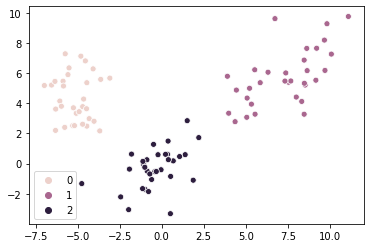

In [23]:
kmeans = Kmeans(3, 100)
kmedoi = K_medoid(3, 100)
kmeans.fit(np.array(data))
kmedoi.fit(np.array(data))
print("kmeans聚类中心：")
print(kmeans.centers)
print("kmedoid聚类中心：")
print(kmedoi.centers)
#show(data, kmeans.labels.astype(np.int32))
show(data, kmedoi.labels.astype(np.int32))

[81, 77, 92, 61, 45, 60, 80, 77, 72, 68, 97, 83, 51, 10, 70, 91, 85, 52, 53, 21]


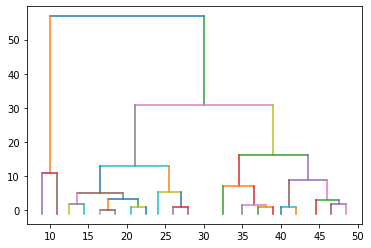

In [7]:
import copy
import queue
import math
class clusterNode:
    def __init__(self, value, id=[],left=None, right=None, distance=-1,  count=-1, check = 0):
        self.value = value
        self.id = id
        self.left = left
        self.right = right
        self.distance = distance
        self.count = count
        self.check = check

class hcluster:
    def distance(self,x,y):
        return np.sum(np.square(x-y), axis=1)
    def minDist(self,dataset):
        #计算所有节点中距离最小的节点对
        mindist = 1000
        for i in range(len(dataset)-1):
            if dataset[i].check == 1:
                continue
            for j in range(i+1,len(dataset)):
                if dataset[j].check == 1:
                    continue
                dist = self.distance(dataset[i],dataset[j])
                if dist < mindist:
                    mindist = dist
                    x, y = i, j
        return mindist, x, y

    def fit(self,data):
        dataset = [clusterNode(value=item,id=[(chr(ord('a')+i))],count=1) for i,item in enumerate(data)]
        #将输入的数据元素转化成节点，并存入节点的列表
        length = len(dataset)
        Backup = copy.deepcopy(dataset)
        #备份数据
        while(True):
            mindist, x, y = self.minDist(dataset)
            dataset[x].check = 1
            dataset[y].check = 1
            tmpid = copy.deepcopy(dataset[x].id)
            tmpid.extend(dataset[y].id)
            dataset.append(clusterNode(value=(dataset[x].value+dataset[y].value)/2,id=tmpid,\
                left=dataset[x],right=dataset[y],distance=mindist,count=dataset[x].count+dataset[y].count))
            #生成新节点
            if len(tmpid) == length:
                #当新生成的节点已经包含所有元素时，退出循环，完成聚类
                break
        return dataset

    def show(self,dataset,num):
        plt.figure(1)
        showqueue = queue.Queue()
        #存放节点信息的队列
        showqueue.put(dataset[len(dataset) - 1])
        #存入根节点
        showqueue.put(num)
        #存入根节点的中心横坐标
        while not showqueue.empty():
            index = showqueue.get()
            #当前绘制的节点
            i = showqueue.get()
            #当前绘制节点中心的横坐标
            left = i - (index.count)/2
            right = i + (index.count)/2
            if index.left != None:
                x = [left,right]
                y = [index.distance,index.distance]
                plt.plot(x,y)
                x = [left,left]
                y = [index.distance,index.left.distance]
                plt.plot(x,y)
                showqueue.put(index.left)
                showqueue.put(left)
            if index.right != None:
                x = [right,right]
                y = [index.distance,index.right.distance]
                plt.plot(x,y)
                showqueue.put(index.right)
                showqueue.put(right)
        plt.show()

def setData(num):
    #生成num个随机数据
    Data = list(np.random.randint(1,100,size=num))
    return Data

if __name__ == '__main__':
    num = 20
    dataset = setData(num)
    print(dataset)
    h = hcluster()
    resultset = h.fit(dataset)
    h.show(resultset,num)